# Import Libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import requests
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

# Read Data

In [2]:
file='C:/Users/Amit/Desktop/Internships/KPMG/dataset.xlsx'
df1 = pd.read_excel(file, sheet_name="CustomerDemographic",header=1)
df2 = pd.read_excel(file, sheet_name="CustomerAddress",header=1)
df3 = pd.read_excel(file, sheet_name="Transactions",header=1)
df4=pd.merge(df1,df2,on='customer_id')

# Pre-processing

In [3]:
# filter rows
df3=df3.loc[df3['order_status']=='Approved']
df4=df4.loc[df4['deceased_indicator']=='N']

# replacing values in columns
df4=df4.replace({'gender': {'F': 'Female','M' : 'Male','Femal':'Female'}})
df4=df4.replace({'state': {'New South Wales': 'NSW','Victoria' : 'VIC'}})

# filling missing values in tenure column
df4['tenure'] = df4['tenure'].fillna((floor(df4['tenure'].mean())))

# filling missing values in DOB column
u = df4.select_dtypes(include=['datetime'])
df4[u.columns] = u.fillna(pd.to_datetime('2017'))

# Feature Engineering

In [4]:
# getting age of customer
df4['age']=df4['DOB'].apply(lambda x: 2017- int(str(x)[:4]))
df4['age'].replace(0,39, inplace=True)

# getting when was the last transaction made by the customer
df3['transaction_recency'] = df3['transaction_date'].max() - df3['transaction_date']
df3['transaction_recency'] /= np.timedelta64(1, 'D')

# get monetary value (target feature)
df3['total_profit_in_2017']=df3["list_price"]-df3["standard_cost"]

# Feature Selection

In [5]:
df4=df4[['customer_id','gender','age',
         'job_industry_category', 'wealth_segment', 'owns_car', 
         'state', 'property_valuation']]


df3 = df3.groupby('customer_id').agg({
    'transaction_recency': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'total_profit_in_2017': lambda x: x.sum()
})


df3.rename(columns={'customer_id': 'no_of_transactions'}, inplace=True)
df3['customer_id']=df3.index
df3.index=range(df3.shape[0])

# Joining tables

In [6]:
df5=pd.merge(df4,df3,on='customer_id',how='inner').drop('customer_id',axis=1)
df5.head()

,gender,age,job_industry_category,wealth_segment,owns_car,state,property_valuation,transaction_recency,no_of_transactions,total_profit_in_2017
0,Female,64,Health,Mass Customer,Yes,NSW,10,7.0,11,3018.09
1,Male,37,Financial Services,Mass Customer,Yes,NSW,10,128.0,3,2226.26
2,Male,56,IT,Mass Customer,No,QLD,9,195.0,2,220.57
3,Female,40,NaN,Affluent Customer,Yes,NSW,4,16.0,6,2394.94
4,Male,51,Retail,High Net Worth,Yes,VIC,9,64.0,5,3946.55


In [7]:
# removing duplicate rows
df5=df5.drop_duplicates()

In [8]:
bins= [15,25,65,100]
labels = ['Youth','Adults','Seniors']
df5['age'] = pd.cut(df5['age'], bins=bins, labels=labels, right=False)

In [9]:
bins= [1,5,9,13]
labels = ['Low','Medium','High']
df5['property_valuation'] = pd.cut(df5['property_valuation'], bins=bins, labels=labels, right=False)

In [10]:
bins= [0,90,180,270,360]
df5['transaction_recency'] = pd.cut(df5['transaction_recency'], bins=bins, right=False)

In [11]:
bins= [1,6,11,16]
labels = ['Low','Medium','High']
df5['no_of_transactions'] = pd.cut(df5['no_of_transactions'], bins=bins, labels=labels, right=False)

In [12]:
df5.head()

,gender,age,job_industry_category,wealth_segment,owns_car,state,property_valuation,transaction_recency,no_of_transactions,total_profit_in_2017
0,Female,Adults,Health,Mass Customer,Yes,NSW,High,"[0, 90)",High,3018.09
1,Male,Adults,Financial Services,Mass Customer,Yes,NSW,High,"[90, 180)",Low,2226.26
2,Male,Adults,IT,Mass Customer,No,QLD,High,"[180, 270)",Low,220.57
3,Female,Adults,NaN,Affluent Customer,Yes,NSW,Low,"[0, 90)",Medium,2394.94
4,Male,Adults,Retail,High Net Worth,Yes,VIC,High,"[0, 90)",Low,3946.55


gender
age
job_industry_category
wealth_segment
owns_car
state
property_valuation
transaction_recency
no_of_transactions


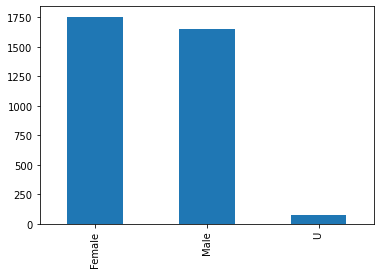

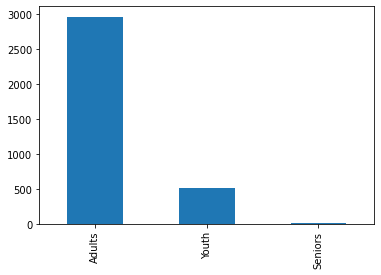

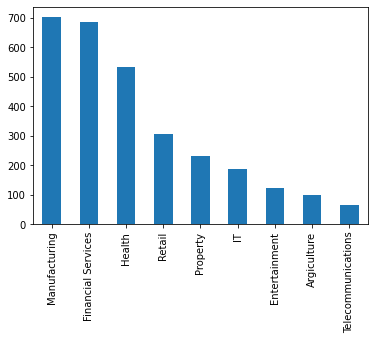

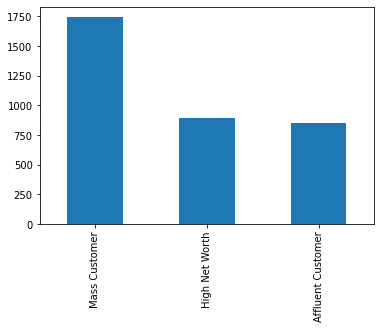

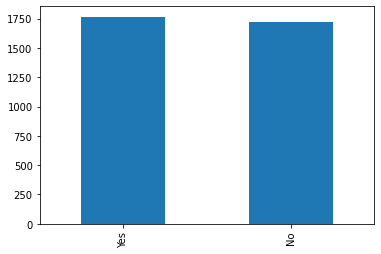

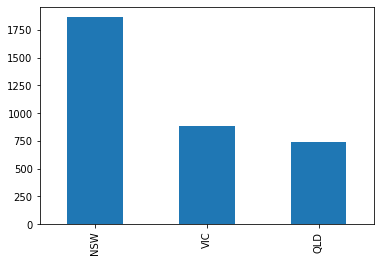

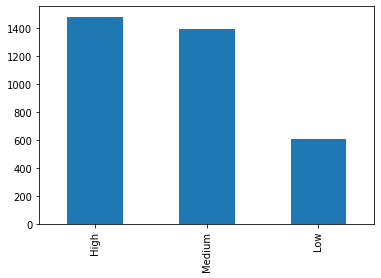

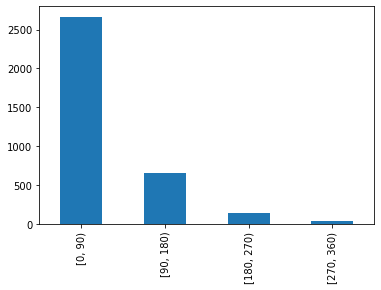

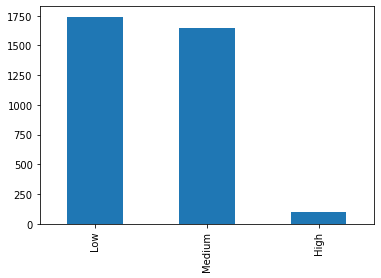

In [13]:
for i in df5.columns[:-1]:
    print(i)
    fig, ax = plt.subplots()
    df5[i].value_counts().plot(ax=ax, kind='bar')

In [ ]:
for i in df.col

<AxesSubplot:ylabel='transaction_recency'>

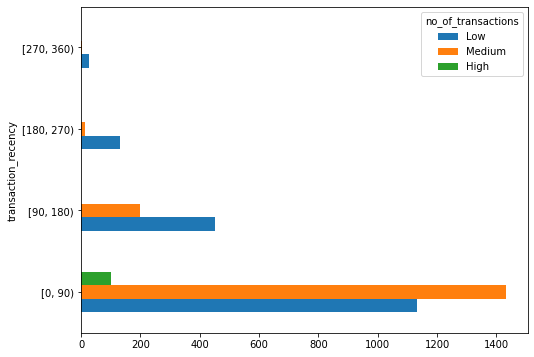

In [14]:
df5.groupby('no_of_transactions')['transaction_recency'].value_counts().unstack(0).plot.barh(figsize=(8, 6))

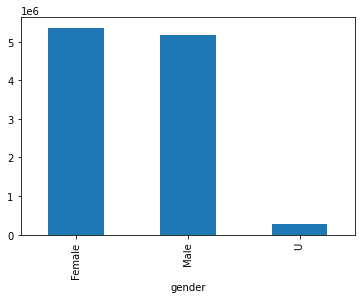

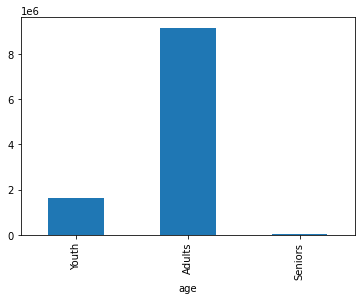

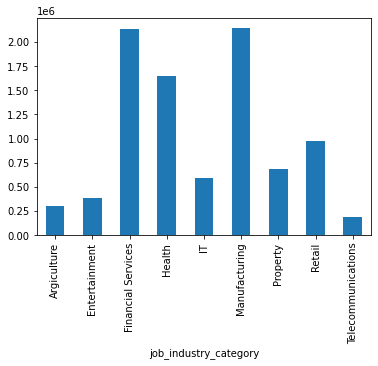

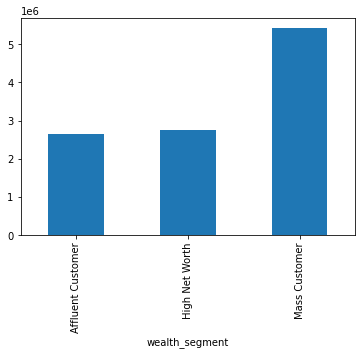

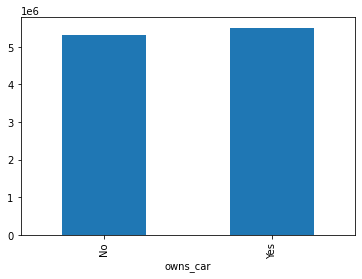

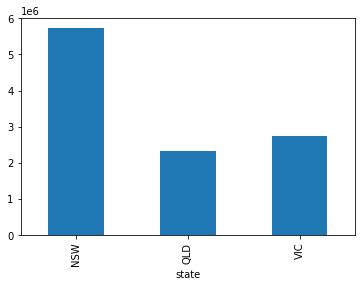

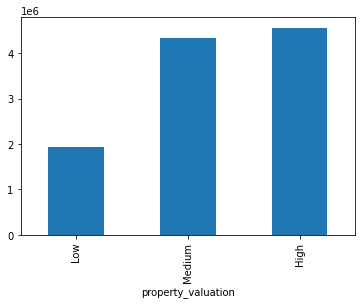

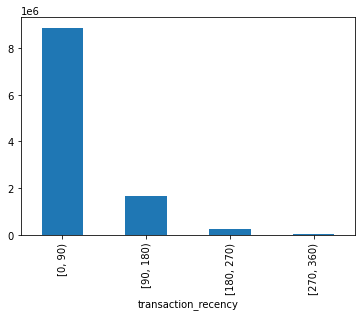

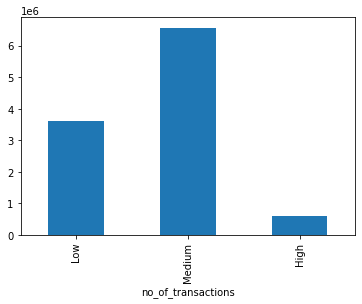

In [15]:
for i in df5.columns[:-1]:
    x = df5.groupby([i])['total_profit_in_2017'].sum()
    plt.figure()
    x.plot.bar()

- Ratio of Male to Female customers is approximately 1:1.
- Most of the customers are adults.
- Most of the customers are from Manufacturing industry.
- Most of the customers are Mass Customers.
- Almost 50% of the customers don't own a car.
- Most of the customers are from NSW, Australia.
- Most of the customers have medium to high property valuation.
- A lot of customers made last purchase within last 3 months of 2017.
- Only a few customers made a large number of transactions in 2017.

- Among the customers who made the last purchase within last 3 months of 2017, a very few of them have made a lot of purchases throughout 2017. This means that those few are frequent customers.

- Male and female contributed equally to profit.
- Most of the profit was made through adults.
- Customers from financial services and manufacturing sector contributed the most to profit.
- Mass customers contributed the most to profit.
- Customers from NSW state contributed the most to profit.
- Customers who made the last purchase within last 3 months of 2017 are the ones who contributed the most to profit.